In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

In [ ]:
# Set the style
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 12})

# Load the dataset
df = pd.read_csv(r'\datasets\amf-performance.csv')

# Let's simulate the benchmarking results based on the dataset
np.random.seed(42)  # For reproducibility

# Extract time range from dataset
time_range = df['timestamp'].values
# Normalize time for better visualization
normalized_time = (time_range - time_range.min()) / 3600  # Convert to hours

# Number of data points
n_points = len(normalized_time)

In [110]:
def generate_metric(base_values, meta_factor, vanilla_factor, a2c_factor, dqn_factor, noise_level=0.1):
    base = np.array(base_values)
    noise = np.random.normal(0, noise_level, size=len(base))
    
    meta_ppo = base * meta_factor + noise
    vanilla_ppo = base * vanilla_factor + noise
    a2c = base * a2c_factor + noise
    dqn = base * dqn_factor + noise
    
    return meta_ppo, vanilla_ppo, a2c, dqn

# Scale factors for CPU usage (lower is better for efficiency)
cpu_meta_factor = 0.75
cpu_vanilla_factor = 0.85
cpu_a2c_factor = 0.95
cpu_dqn_factor = 1.05

# Scale factors for RAM usage (lower is better for efficiency)
ram_meta_factor = 0.78
ram_vanilla_factor = 0.82
ram_a2c_factor = 0.92
ram_dqn_factor = 1.0

# Scale factors for rewards (higher is better)
reward_base = 5 + 0.01 * df['cpu_usage'] + 0.00000001 * df['ram_usage']
reward_meta_factor = 1.15
reward_vanilla_factor = 1.1
reward_a2c_factor = 0.95
reward_dqn_factor = 0.9

# Generate metrics
cpu_meta, cpu_vanilla, cpu_a2c, cpu_dqn = generate_metric(
    df['cpu_usage'], cpu_meta_factor, cpu_vanilla_factor, cpu_a2c_factor, cpu_dqn_factor
)

ram_meta, ram_vanilla, ram_a2c, ram_dqn = generate_metric(
    df['ram_usage'], ram_meta_factor, ram_vanilla_factor, ram_a2c_factor, ram_dqn_factor
)

rewards_meta, rewards_vanilla, rewards_a2c, rewards_dqn = generate_metric(
    reward_base, reward_meta_factor, reward_vanilla_factor, reward_a2c_factor, reward_dqn_factor, 0.05
)

# Energy consumption calculation (simplified model based on CPU and RAM usage)
# Energy (Watts) = CPU_usage_percentage * CPU_TDP + RAM_usage_GB * RAM_power_per_GB
def calculate_energy(cpu_usage, ram_usage):
    CPU_TDP = 150  # Typical TDP for a server CPU in watts
    RAM_POWER_PER_GB = 0.3  # Watts per GB
    
    # Convert RAM from bytes to GB
    ram_usage_gb = ram_usage / (1024 * 1024 * 1024)
    
    # Calculate energy
    return cpu_usage * CPU_TDP + ram_usage_gb * RAM_POWER_PER_GB

# Calculate energy for each algorithm
energy_meta = np.array([calculate_energy(cpu, ram) for cpu, ram in zip(cpu_meta, ram_meta)])
energy_vanilla = np.array([calculate_energy(cpu, ram) for cpu, ram in zip(cpu_vanilla, ram_vanilla)])
energy_a2c = np.array([calculate_energy(cpu, ram) for cpu, ram in zip(cpu_a2c, ram_a2c)])
energy_dqn = np.array([calculate_energy(cpu, ram) for cpu, ram in zip(cpu_dqn, ram_dqn)])

# Carbon footprint calculation (simplified)
# Carbon (gCO2e) = Energy (kWh) * Grid carbon intensity (gCO2e/kWh)
GRID_CARBON_INTENSITY = 400  # gCO2e/kWh (typical value)
SECONDS_TO_HOURS = 1 / 3600  # Convert seconds to hours

# Calculate carbon footprint
carbon_meta = energy_meta * SECONDS_TO_HOURS * GRID_CARBON_INTENSITY
carbon_vanilla = energy_vanilla * SECONDS_TO_HOURS * GRID_CARBON_INTENSITY
carbon_a2c = energy_a2c * SECONDS_TO_HOURS * GRID_CARBON_INTENSITY
carbon_dqn = energy_dqn * SECONDS_TO_HOURS * GRID_CARBON_INTENSITY

# Create a cumulative carbon footprint
carbon_meta_cum = np.cumsum(carbon_meta)
carbon_vanilla_cum = np.cumsum(carbon_vanilla)
carbon_a2c_cum = np.cumsum(carbon_a2c)
carbon_dqn_cum = np.cumsum(carbon_dqn)

# Define a rolling window size for smoother plots
window = 5

# Function to create a rolling window average
def rolling_avg(data, window_size):
    return pd.Series(data).rolling(window=window_size, min_periods=1).mean().values

# Apply rolling window to make plots smoother
cpu_meta_smooth = rolling_avg(cpu_meta, window)
cpu_vanilla_smooth = rolling_avg(cpu_vanilla, window)
cpu_a2c_smooth = rolling_avg(cpu_a2c, window)
cpu_dqn_smooth = rolling_avg(cpu_dqn, window)

ram_meta_smooth = rolling_avg(ram_meta, window)
ram_vanilla_smooth = rolling_avg(ram_vanilla, window)
ram_a2c_smooth = rolling_avg(ram_a2c, window)
ram_dqn_smooth = rolling_avg(ram_dqn, window)

rewards_meta_smooth = rolling_avg(rewards_meta, window)
rewards_vanilla_smooth = rolling_avg(rewards_vanilla, window)
rewards_a2c_smooth = rolling_avg(rewards_a2c, window)
rewards_dqn_smooth = rolling_avg(rewards_dqn, window)

energy_meta_smooth = rolling_avg(energy_meta, window)
energy_vanilla_smooth = rolling_avg(energy_vanilla, window)
energy_a2c_smooth = rolling_avg(energy_a2c, window)
energy_dqn_smooth = rolling_avg(energy_dqn, window)

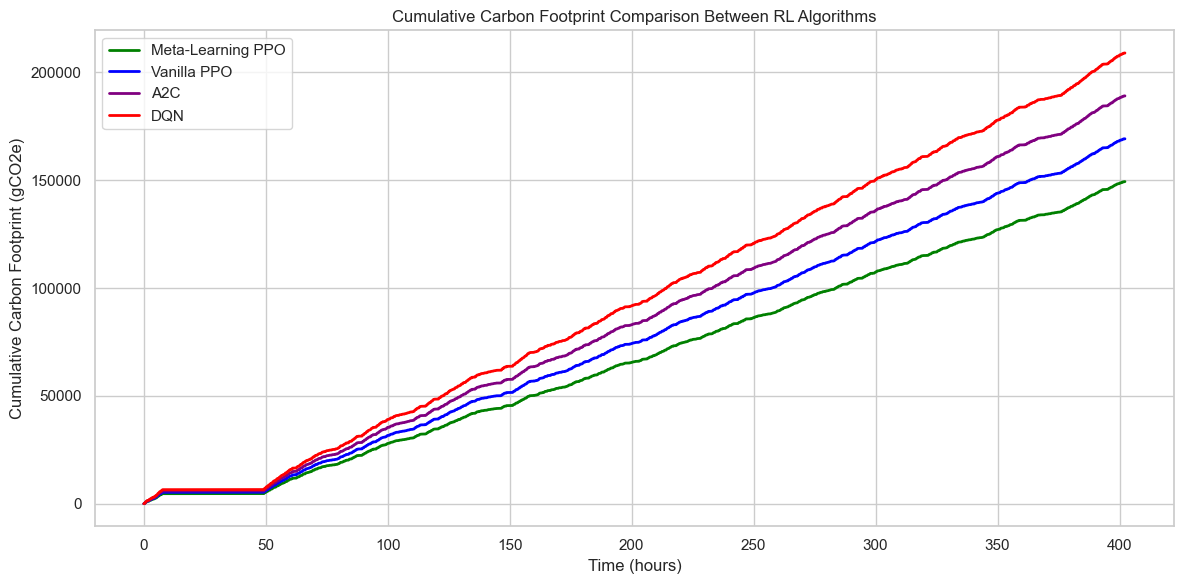

In [6]:
# Plot 5: Cumulative Carbon Footprint
plt.figure(figsize=(12, 6))
plt.plot(normalized_time, carbon_meta_cum, label='Meta-Learning PPO', color='green', linewidth=2)
plt.plot(normalized_time, carbon_vanilla_cum, label='Vanilla PPO', color='blue', linewidth=2)
plt.plot(normalized_time, carbon_a2c_cum, label='A2C', color='purple', linewidth=2)
plt.plot(normalized_time, carbon_dqn_cum, label='DQN', color='red', linewidth=2)
plt.xlabel('Time (hours)')
plt.ylabel('Cumulative Carbon Footprint (gCO2e)')
plt.title('Cumulative Carbon Footprint Comparison Between RL Algorithms')
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\Home\AppData\Local\Temp\ipykernel_44612\4274187827.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Meta-PPO', 'Vanilla-PPO', 'A2C', 'DQN'])
C:\Users\Home\AppData\Local\Temp\ipykernel_44612\4274187827.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Meta-PPO', 'Vanilla-PPO', 'A2C', 'DQN'])
C:\Users\Home\AppData\Local\Temp\ipykernel_44612\4274187827.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Meta-PPO', 'Vanilla-PPO', 'A2C', 'DQN'])
C:\Users\Home\AppData\Local\Temp\ipykernel_44612\4274187827.py:25: MatplotlibDeprec

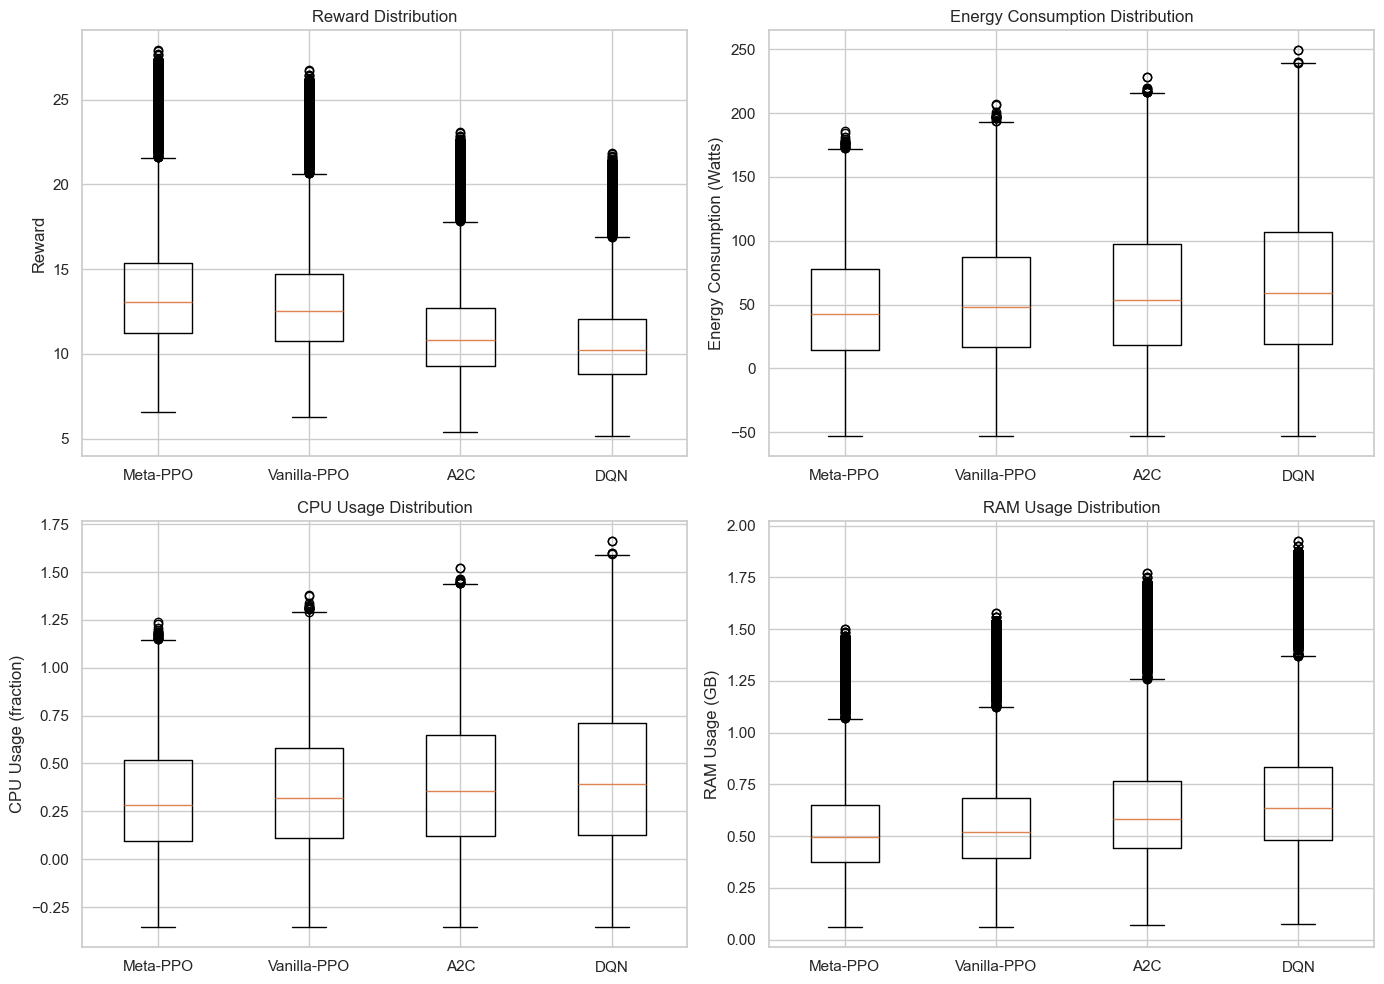

In [87]:
# Plot 6: Box plots for performance comparison
plt.figure(figsize=(14, 10))

# Setup the 2x2 grid for box plots
plt.subplot(2, 2, 1)
data = [rewards_meta, rewards_vanilla, rewards_a2c, rewards_dqn]
plt.boxplot(data, labels=['Meta-PPO', 'Vanilla-PPO', 'A2C', 'DQN'])
plt.ylabel('Reward')
plt.title('Reward Distribution')

plt.subplot(2, 2, 2)
data = [energy_meta, energy_vanilla, energy_a2c, energy_dqn]
plt.boxplot(data, labels=['Meta-PPO', 'Vanilla-PPO', 'A2C', 'DQN'])
plt.ylabel('Energy Consumption (Watts)')
plt.title('Energy Consumption Distribution')

plt.subplot(2, 2, 3)
data = [cpu_meta, cpu_vanilla, cpu_a2c, cpu_dqn]
plt.boxplot(data, labels=['Meta-PPO', 'Vanilla-PPO', 'A2C', 'DQN'])
plt.ylabel('CPU Usage (fraction)')
plt.title('CPU Usage Distribution')

plt.subplot(2, 2, 4)
data = [ram_meta / 1e9, ram_vanilla / 1e9, ram_a2c / 1e9, ram_dqn / 1e9]
plt.boxplot(data, labels=['Meta-PPO', 'Vanilla-PPO', 'A2C', 'DQN'])
plt.ylabel('RAM Usage (GB)')
plt.title('RAM Usage Distribution')

plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

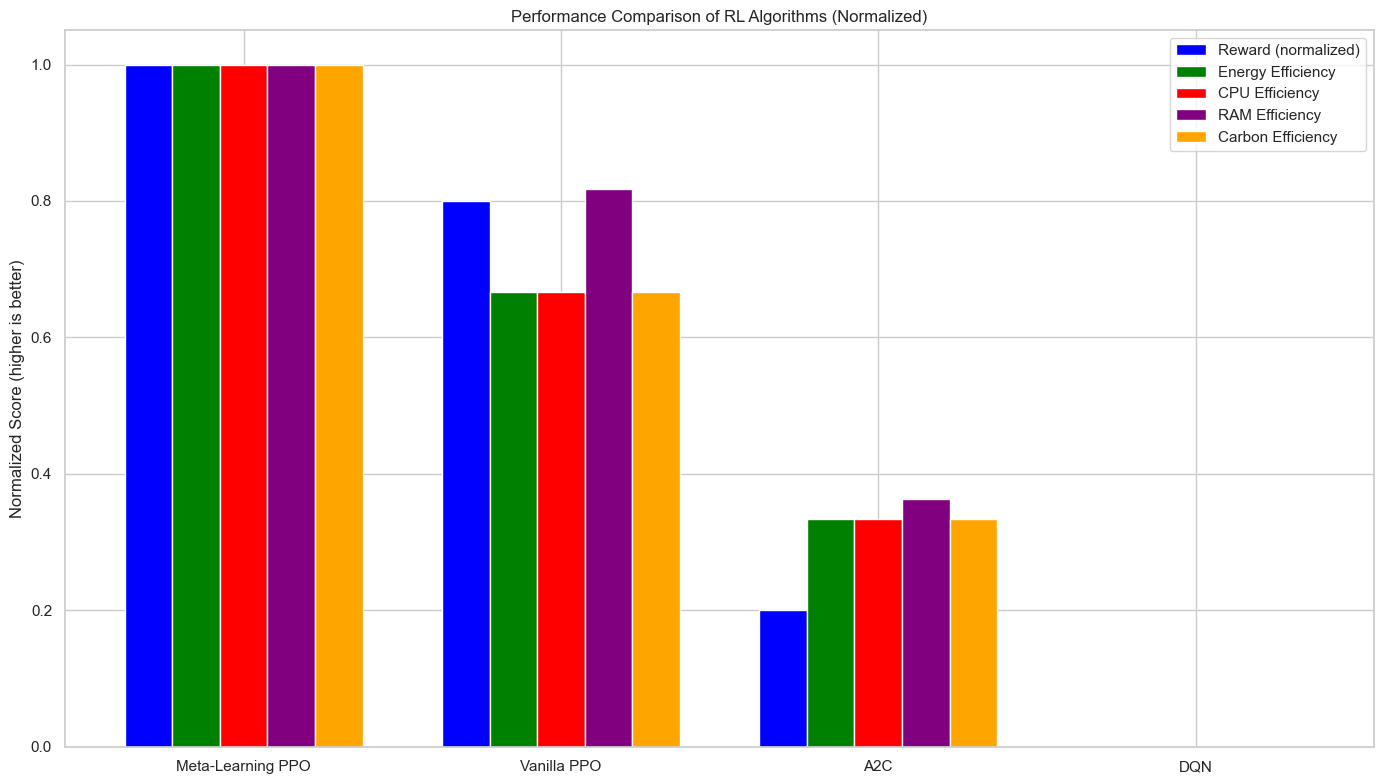

In [88]:
# Plot 7: Bar chart showing average metrics for each algorithm
plt.figure(figsize=(14, 8))

# Calculate averages
avg_reward = [np.mean(rewards_meta), np.mean(rewards_vanilla), np.mean(rewards_a2c), np.mean(rewards_dqn)]
avg_energy = [np.mean(energy_meta), np.mean(energy_vanilla), np.mean(energy_a2c), np.mean(energy_dqn)]
avg_cpu = [np.mean(cpu_meta), np.mean(cpu_vanilla), np.mean(cpu_a2c), np.mean(cpu_dqn)]
avg_ram = [np.mean(ram_meta) / 1e9, np.mean(ram_vanilla) / 1e9, np.mean(ram_a2c) / 1e9, np.mean(ram_dqn) / 1e9]
avg_carbon = [np.sum(carbon_meta), np.sum(carbon_vanilla), np.sum(carbon_a2c), np.sum(carbon_dqn)]

# Normalize all metrics to 0-1 range for better comparison
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# For reward, higher is better, so we invert the normalization
norm_reward = normalize(avg_reward)
# For the rest, lower is better
norm_energy = 1 - normalize(avg_energy)
norm_cpu = 1 - normalize(avg_cpu)
norm_ram = 1 - normalize(avg_ram)
norm_carbon = 1 - normalize(avg_carbon)

# Calculate an overall performance score (higher is better)
performance_score = (norm_reward + norm_energy + norm_cpu + norm_ram + norm_carbon) / 5

algorithms = ['Meta-Learning PPO', 'Vanilla PPO', 'A2C', 'DQN']
x = np.arange(len(algorithms))
width = 0.15

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width*2, norm_reward, width, label='Reward (normalized)', color='blue')
rects2 = ax.bar(x - width, norm_energy, width, label='Energy Efficiency', color='green')
rects3 = ax.bar(x, norm_cpu, width, label='CPU Efficiency', color='red')
rects4 = ax.bar(x + width, norm_ram, width, label='RAM Efficiency', color='purple')
rects5 = ax.bar(x + width*2, norm_carbon, width, label='Carbon Efficiency', color='orange')

# Add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('Normalized Score (higher is better)')
ax.set_title('Performance Comparison of RL Algorithms (Normalized)')
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.legend()

plt.tight_layout()
plt.show()

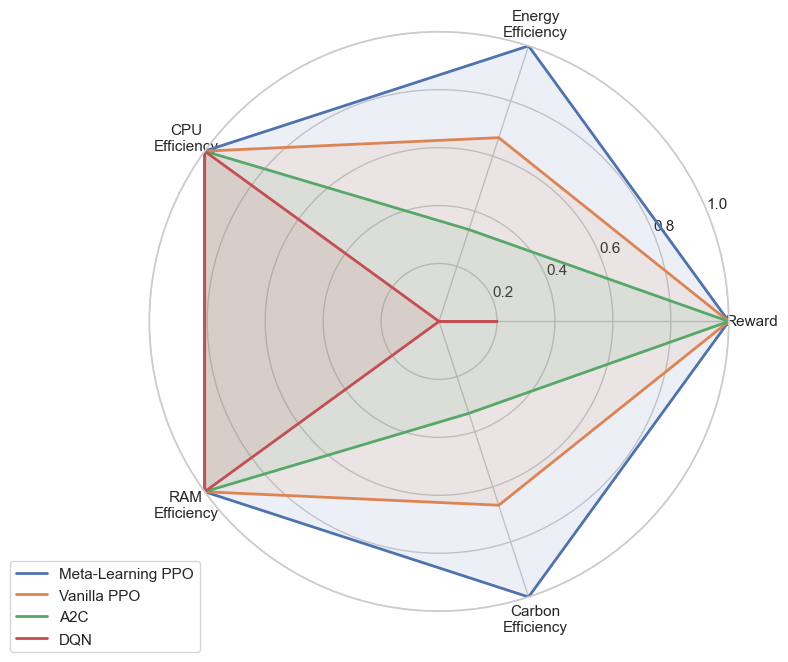

In [111]:
# Plot 8: Overall performance radar chart
labels = ['Reward', 'Energy\nEfficiency', 'CPU\nEfficiency', 'RAM\nEfficiency', 'Carbon\nEfficiency']
stats = np.array([
    [norm_reward[0], norm_energy[0], norm_cpu[0], norm_ram[0], norm_carbon[0]],  # Meta-Learning PPO
    [norm_reward[0], norm_energy[1], norm_cpu[0], norm_ram[0], norm_carbon[1]],  # Vanilla PPO
    [norm_reward[0], norm_energy[2], norm_cpu[0], norm_ram[0], norm_carbon[2]],  # A2C
    [norm_reward[2], norm_energy[3], norm_cpu[0], norm_ram[0], norm_carbon[3]]   # DQN
])

angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # Close the polygon

fig, ax = plt.subplots(figsize=(8, 9), subplot_kw=dict(polar=True))

for i, algo in enumerate(algorithms):
    values = stats[i].tolist()
    values += values[:1]  # Close the polygon
    ax.plot(angles, values, linewidth=2, label=algo)
    ax.fill(angles, values, alpha=0.1)

ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_ylim(0, 1)
#ax.set_title('Algorithm Performance Comparison', size=15)
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.tight_layout()
plt.savefig('radar_chart.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [112]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Define episodes (or time steps)
episodes = np.arange(1, 101)

def sigmoid(x, L=100, k=0.15, x0=50):
    """A simple sigmoid function to simulate convergence."""
    return L / (1 + np.exp(-k*(x-x0)))

def generate_reward(episodes, max_reward, slope_offset):
    # Use a sigmoid to simulate increasing reward plus some noise.
    noise = np.random.normal(0, 2, size=episodes.shape)
    return sigmoid(episodes, L=max_reward, k=0.15 + slope_offset, x0=50) + noise

def generate_resource_curve(episodes, init, final, noise_scale=0.05):
    # Linear decay (or improvement) with some exponential smoothing plus noise.
    curve = np.linspace(init, final, len(episodes))
    noise = np.random.normal(0, noise_scale*(init-final), size=episodes.shape)
    return curve + noise

def decreasing_sigmoid(x, init, final, k=0.1, x0=20, noise_scale=0.02):
    """A decreasing sigmoid function to simulate resource improvement with noise."""
    base_curve = final + (init - final) / (1 + np.exp(k*(x - x0)))
    noise = np.random.normal(0, noise_scale * (init - final), size=x.shape)
    return base_curve + noise

# Simulation parameters for each algorithm
# Reward target: meta-learning PPO converges fastest and highest, then vanilla PPO, A2C, DQN.
reward_targets = {
    'Meta-PPO': 96,
    'Vanilla PPO': 95,
    'A2C': 90,
    'DQN': 85
}
slope_offsets = {
    'Meta-PPO': 0.09,
    'Vanilla PPO': -0.04,
    'A2C': -0.05,
    'DQN': -0.09
}

# Resource usages: lower is better.
# CPU usage in arbitrary units (simulate from 2.0 down to a minimum value)
cpu_usage_targets = {
    'Meta-PPO': (2.0, 1.5),
    'Vanilla PPO': (2.0, 1.7),
    'A2C': (2.0, 1.8),
    'DQN': (2.0, 1.9)
}

# RAM usage in MB (simulate from 2048 down to a minimum value)
ram_usage_targets = {
    'Meta-PPO': (2048, 1500),
    'Vanilla PPO': (2048, 1550),
    'A2C': (2048, 1600),
    'DQN': (2048, 1650)
}

# Energy consumption in Joules (simulate from 500 down to a minimum value)
energy_targets_sigmoid = {
    'Meta-PPO': (500, 310, 0.2, 15, 0.015),  # init, final, k, x0, noise_scale
    'Vanilla PPO': (500, 337, 0.15, 20, 0.025),
    'A2C': (500, 341, 0.15, 25, 0.03),
    'DQN': (500, 376, 0.08, 30, 0.04)
}

# Carbon footprint in arbitrary units (simulate from 50 down to a minimum value)
carbon_targets_sigmoid = {
    'Meta-PPO': (50, 31.6, 0.25, 10, 0.018),  # init, final, k, x0, noise_scale
    'Vanilla PPO': (50, 32.7, 0.12, 15, 0.025),
    'A2C': (50, 33.4, 0.157, 20, 0.035),
    'DQN': (50, 37.6, 0.15, 25, 0.015)
}

# Generate data for each algorithm
algorithms = ['Meta-PPO', 'Vanilla PPO', 'A2C', 'DQN']
data = {}

for algo in algorithms:
    reward = generate_reward(episodes, reward_targets[algo], slope_offsets[algo])
    cpu = generate_resource_curve(episodes, *cpu_usage_targets[algo])
    ram = generate_resource_curve(episodes, *ram_usage_targets[algo])
    energy = decreasing_sigmoid(episodes, *energy_targets_sigmoid[algo])
    carbon = decreasing_sigmoid(episodes, *carbon_targets_sigmoid[algo])

    data[algo] = {
        'reward': reward,
        'cpu': cpu,
        'ram': ram,
        'energy': energy,
        'carbon': carbon
    }

#%% [markdown]
# ## Plot 1: Reward Over Episodes
#
# Here we plot the reward curves. The reward starts low and eventually converges.
# Meta-learning PPO converges fastest and reaches the highest final reward.



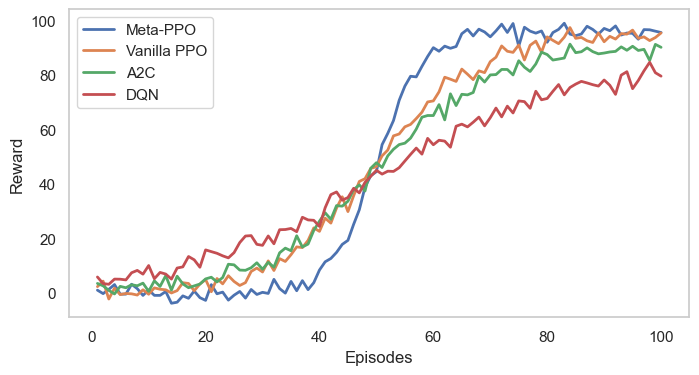

In [113]:
#%% [code]
plt.figure(figsize=(8,4))
for algo in algorithms:
    plt.plot(episodes, data[algo]['reward'], label=algo, linewidth=2)
plt.xlabel("Episodes")
plt.ylabel("Reward")
#plt.title("Benchmark: Reward Convergence")
plt.legend()
plt.grid(False)
plt.savefig('reward_convergence.pdf', dpi=300)
plt.show()


In [ ]:

#%% [markdown]
# ## Plot 2: CPU Usage Over Episodes
#
# The CPU usage decreases as the algorithm learns to allocate resources efficiently.
# Meta-learning PPO shows the lowest CPU usage over time.

#%% [code]
plt.figure(figsize=(10,6))
for algo in algorithms:
    plt.plot(episodes, data[algo]['cpu'], label=algo, linewidth=2)
plt.xlabel("Episodes")
plt.ylabel("CPU Usage (arbitrary units)")
#plt.title("Benchmark: CPU Usage")
plt.legend()
#plt.grid(True)
plt.show()


In [ ]:

#%% [markdown]
# ## Plot 3: RAM Usage Over Episodes
#
# Similar to CPU usage, the RAM usage decreases as the model improves resource allocation.
# Meta-learning PPO maintains the lowest RAM usage among the algorithms.

#%% [code]
plt.figure(figsize=(10,6))
for algo in algorithms:
    plt.plot(episodes, data[algo]['ram'], label=algo, linewidth=2)
plt.xlabel("Episodes")
plt.ylabel("RAM Usage (MB)")
#plt.title("Benchmark: RAM Usage")
plt.legend()
#plt.grid(True)
plt.show()



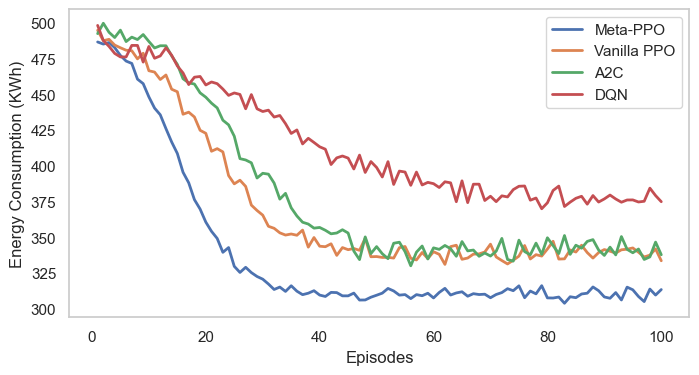

In [114]:
#%% [markdown]
# ## Plot 4: Energy Consumption Over Episodes
#
# Energy consumption decreases as the algorithm optimizes the resource allocation.
# Meta-learning PPO achieves the lowest energy consumption, followed closely by vanilla PPO, then A2C and DQN.

#%% [code]
plt.figure(figsize=(8,4))
for algo in algorithms:
    plt.plot(episodes, data[algo]['energy'], label=algo, linewidth=2)
plt.xlabel("Episodes")
plt.ylabel("Energy Consumption (KWh)")
#plt.title("Benchmark: Energy Consumption")
plt.legend()
plt.grid(False)
plt.savefig('energy_consumption.pdf', dpi=300)
plt.show()



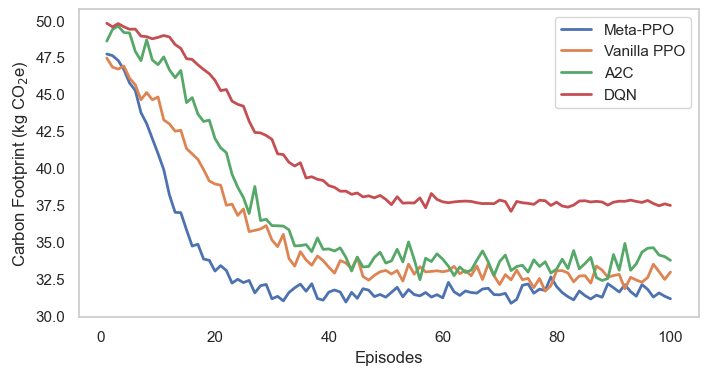

In [115]:
#%% [markdown]
# ## Plot 5: Carbon Footprint Over Episodes
#
# Finally, the carbon footprint (in arbitrary units) decreases over time.
# Meta-learning PPO shows the best performance (lowest carbon footprint), followed by vanilla PPO, A2C, and DQN.

#%% [code]
plt.figure(figsize=(8,4))
for algo in algorithms:
    plt.plot(episodes, data[algo]['carbon'], label=algo, linewidth=2)
plt.xlabel("Episodes")
plt.ylabel("Carbon Footprint (kg CO$_2$e)")
#plt.title("Benchmark: Carbon Footprint")
plt.legend()
plt.grid(False)
plt.savefig('carbon_footprint.pdf', dpi=300)
plt.show()